In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python import utils as putils #.utils import label_figure, natural_keys, convert_range
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.retinotopy import segment_retinotopy as seg

from matplotlib.patches import Ellipse, Rectangle

from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import matplotlib_venn as mpvenn
import itertools


/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib notebook

In [3]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
traceid='traces001'
state='awake'

In [4]:
all_rats = [os.path.split(os.path.split(f)[0])[-1] for f in glob.glob(os.path.join(rootdir, 'JC*', 'sessionmeta.json'))]
print(sorted(all_rats, key=putils.natural_keys))

['JC061', 'JC067', 'JC070', 'JC073', 'JC076', 'JC078', 'JC080', 'JC083', 'JC084', 'JC085', 'JC086', 'JC089', 'JC090', 'JC091', 'JC092', 'JC097', 'JC099', 'JC101', 'JC110', 'JC111', 'JC113', 'JC117', 'JC120']


# Get list of all datasets

In [5]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [6]:
visual_areas = ['V1', 'Lm', 'Li']

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state, create_new=False)
print(sdata['experiment'].unique())

['rfs' 'gratings' 'blobs' 'retino' 'rfs10']


In [9]:
response_type='dff'
responsive_test='nstds'
responsive_thr=10
trial_epoch = 'stimulus'

# retino
retino_mag_thr=0.01
retino_pass_criterion='max'
verbose=False


c_=[]
missing_seg=[]
for experiment in ['gratings', 'blobs', 'rfs', 'retino']:
    if experiment == 'rfs':
        edata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
        # rfdf = aggr.load_rfdf_and_pos(edata, response_type=response_type, 
        #                               rf_filter_by=None, reliable_only=True)
        assigned_rois, missing_ = seg.get_cells_by_area(edata, return_missing=True)
        tmpcells = aggr.get_dsets_with_max_rfs(edata, assigned_rois)
    elif experiment=='retino':
        edata = sdata[sdata['experiment'].isin(['retino'])]
        assigned_rois, missing_ = seg.get_cells_by_area(edata, return_missing=True)
        tmpcells = aggr.aggregate_responsive_retino(assigned_rois, traceid=traceid,
                                               mag_thr=retino_mag_thr, 
                                               pass_criterion=retino_pass_criterion, verbose=verbose,
                                                create_new=False)
    else:
        exp_meta, tmpcells, EXP, missing_ = aggr.get_source_data(experiment, 
                                            response_type=response_type,
                                            responsive_test=responsive_test, 
                                            responsive_thr=responsive_thr, 
                                            trial_epoch=trial_epoch,
                                            return_missing=True)
        
    cells_ = tmpcells[tmpcells['visual_area'].isin(visual_areas)]
    #cells.groupby(['visual_area']).count()
    cells_['experiment'] = experiment
    print(cells_.shape)
    c_.append(cells_)
    missing_seg.extend(missing_)
    
aggr_cells = pd.concat(c_, axis=0).reset_index(drop=True)

missing_seg = list(set(missing_seg))
assert len([k for k in aggr_cells['datakey'].unique() if k in missing_seg])==0, \
"There are included dsets w/ missing seg. Fix this."


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
... skipping 20190314_JC070_fov1 (retino_run2)
... skipping 20190314_JC070_fov2 (retino_run1)
... skipping 20190321_JC070_fov2 (retino_run1)
... skipping 20190321_JC073_fov1 (retino_run1)
... skipping 20190321_JC073_fov1 (retino_run2)
... skipping 20191008_JC091_fov1 (retino_run1)
Segmentation: missing 6 dsets
(1663, 8)
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
... skipping 20190314_JC070_fov1 (retino_run2)
... skipping 20190327_JC073_fov1 (retino_incomplete)
... skipping 20190327_JC073_fov1 (retino_run1)
... skipping 20190327_JC073_fov1 (retino_run2)
... skipping 20191008_JC091_fov1 (retino_run1)
Segmentation: missing 5 dsets
(4684, 8)
... skipping 20191008_JC091_fov1 (retino_run1)
... skipping 20191012_JC113_fov3 (retino_run1)
... skipping 20191108_JC113_fov2

In [35]:
all_rois = seg.get_cells_by_area(sdata)

... skipping 20190314_JC070_fov1 (retino_run2)
... skipping 20190314_JC070_fov2 (retino_run1)
... skipping 20190315_JC070_fov3 (retino_run1)
... skipping 20190321_JC070_fov2 (retino_run1)
... skipping 20190321_JC073_fov1 (retino_run1)
... skipping 20190321_JC073_fov1 (retino_run2)
... skipping 20190327_JC073_fov1 (retino_incomplete)
... skipping 20190327_JC073_fov1 (retino_run1)
... skipping 20190327_JC073_fov1 (retino_run2)
... skipping 20191008_JC091_fov1 (retino_run1)
... skipping 20191012_JC113_fov3 (retino_run1)
... skipping 20191108_JC113_fov2 (retino_run1)
Segmentation: missing 12 dsets


In [84]:
aggr_cells.head()

,animalid,cell,datakey,experiment,fov,fovnum,session,visual_area
0,JC089,128.0,20190522_JC089_fov1,gratings,FOV1_zoom2p0x,1.0,20190522,Li
1,JC089,134.0,20190522_JC089_fov1,gratings,FOV1_zoom2p0x,1.0,20190522,Li
2,JC089,137.0,20190522_JC089_fov1,gratings,FOV1_zoom2p0x,1.0,20190522,Li
3,JC089,140.0,20190522_JC089_fov1,gratings,FOV1_zoom2p0x,1.0,20190522,Li
4,JC089,108.0,20190522_JC089_fov1,gratings,FOV1_zoom2p0x,1.0,20190522,Li


In [97]:
def get_ncells_by_experiment(aggr_cells, total_nrois, experiment=None):
    
    if experiment is None:
        # Get all cells
        visual_cells = aggr_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()
    else:
        if isinstance(experiment, str):
            curr_cells = aggr_cells[aggr_cells['experiment']==experiment].copy()
        else:
            curr_cells = aggr_cells[aggr_cells['experiment'].isin(experiment)].copy()
        visual_cells = curr_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()
    # get counts
    total_visual = visual_cells.groupby(['visual_area', 'datakey']).count().reset_index()\
                    .rename(columns={'cell': 'visual'})
    counts = total_visual.merge(total_nrois)
    counts['fraction'] = counts['visual']/counts['total']
    
    #total_visual.groupby(['visual_area']).sum()
    return counts

In [98]:
# Get alL rois
total_nrois = all_rois[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'total'})
print(total_nrois.shape)
#total_nrois.groupby(['visual_area']).sum()

(77, 3)


In [111]:
# Get all cells
visual_cells = get_ncells_by_experiment(aggr_cells, total_nrois, experiment=None)
gratings_cells = get_ncells_by_experiment(aggr_cells, total_nrois, experiment='gratings')
blobs_cells = get_ncells_by_experiment(aggr_cells, total_nrois, experiment='blobs')
rf_cells = get_ncells_by_experiment(aggr_cells, total_nrois, experiment=['rfs', 'rfs10'])
retino_cells = get_ncells_by_experiment(aggr_cells, total_nrois, experiment='retino')


In [115]:
counts={'total': visual_cells, 
        'gratings': gratings_cells, 
        'blobs': blobs_cells, 
        'rfs': rf_cells, 
        'retino': retino_cells}

<IPython.core.display.Javascript object>


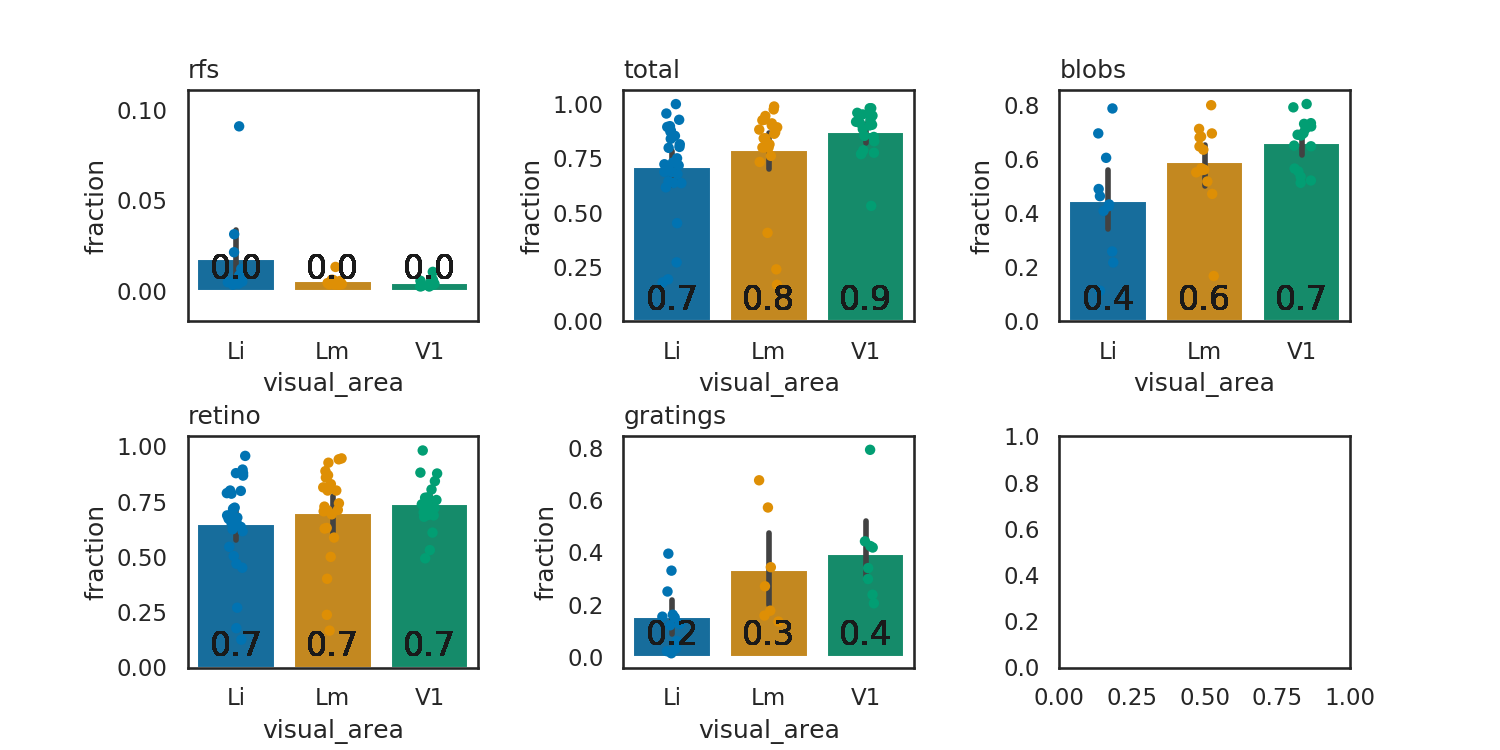

In [117]:
fig, axn = pl.subplots(2,3, figsize=(10, 5))

for i, (experiment_name, curr_counts) in enumerate(counts.items()):
    ax =axn.flat[i]
    ax.set_title(experiment_name, loc='left', fontsize=12)
    sns.stripplot(x='visual_area', y='fraction', data=curr_counts, ax=ax)
    sns.barplot(x='visual_area', y='fraction', data=curr_counts, ax=ax)
    curr_counts.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=16, 
                         fontcolor='k', xytext=(0, 10), fmt='%.1f')

pl.subplots_adjust(wspace=0.5, hspace=0.5)

In [104]:
visual_cells

,visual_area,datakey,visual,total,fraction
0,Li,20190314_JC070_fov1,99,137,0.722628
1,Li,20190315_JC070_fov1,159,181,0.878453
2,Li,20190315_JC070_fov2,46,102,0.450980
3,Li,20190316_JC070_fov1,103,152,0.677632
4,Li,20190319_JC067_fov1,44,46,0.956522
5,Li,20190320_JC067_fov1,17,19,0.894737
6,Li,20190321_JC070_fov1,95,119,0.798319
7,Li,20190322_JC073_fov1,137,191,0.717277
8,Li,20190327_JC073_fov1,30,111,0.270270
9,Li,20190422_JC076_fov1,33,33,1.000000


In [13]:
experiment_types = sorted(sdata['experiment'].unique(), key=putils.natural_keys)
experiment_ids = dict((exp, i) for i, exp in enumerate(experiment_types))
animal_names = sorted(sdata['animalid'].unique(), key=putils.natural_keys)
animal_ids = dict((animal, i) for i, animal in enumerate(animal_names))

sdata['exp_no'] = [int(experiment_ids[exp]) for exp in sdata['experiment']]
sdata['animal_no'] = [int(animal_ids[animal]) for animal in sdata['animalid']]

In [14]:
sdata.head()

,animalid,datakey,experiment,fov,fovnum,session,visual_area,exp_no,animal_no
0,JC084,20190522_JC084_fov1,rfs,FOV1_zoom2p0x,1,20190522,V1,3,8
1,JC084,20190522_JC084_fov1,gratings,FOV1_zoom2p0x,1,20190522,V1,1,8
2,JC084,20190522_JC084_fov1,blobs,FOV1_zoom2p0x,1,20190522,V1,0,8
3,JC084,20190522_JC084_fov1,retino,FOV1_zoom2p0x,1,20190522,V1,2,8
4,JC084,20190525_JC084_fov1,rfs,FOV1_zoom2p0x,1,20190525,Lm,3,8


In [15]:
experiments_per_animal = sdata.groupby(['visual_area', 'animalid', 'experiment']).size()\
                                .reset_index().rename(columns={0: 'N'})

In [16]:
n_animals_per = sdata.groupby(['visual_area'])['animalid'].unique()
    
group_by_animal = [len(s) for s in n_animals_per] #.reset_index().pivot(columns='animalid', index='visual_area', values=0)
print(group_by_animal)
n_animals_per

[13, 14, 9]


visual_area
Li    [JC111, JC091, JC089, JC090, JC099, JC092, JC1...
Lm    [JC084, JC091, JC097, JC110, JC117, JC120, JC0...
V1    [JC084, JC085, JC097, JC110, JC117, JC120, JC0...
Name: animalid, dtype: object

In [17]:
group_by_area = sdata.groupby(['visual_area', 'experiment']).size().reset_index()\
                        .pivot(columns='experiment', index='visual_area', values=0)
group_by_experiment = sdata.groupby(['visual_area', 'experiment']).size().reset_index()\
                        .pivot(columns='visual_area', index='experiment', values=0)


In [18]:
sdata[sdata['animalid']=='JC080']['session'].unique()

array(['20190603', '20190506', '20190602'], dtype=object)

# Create output figure dir:

In [19]:
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
dst_dir = os.path.join(aggr_dir, 'data-stats', 'figures')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    

<IPython.core.display.Javascript object>


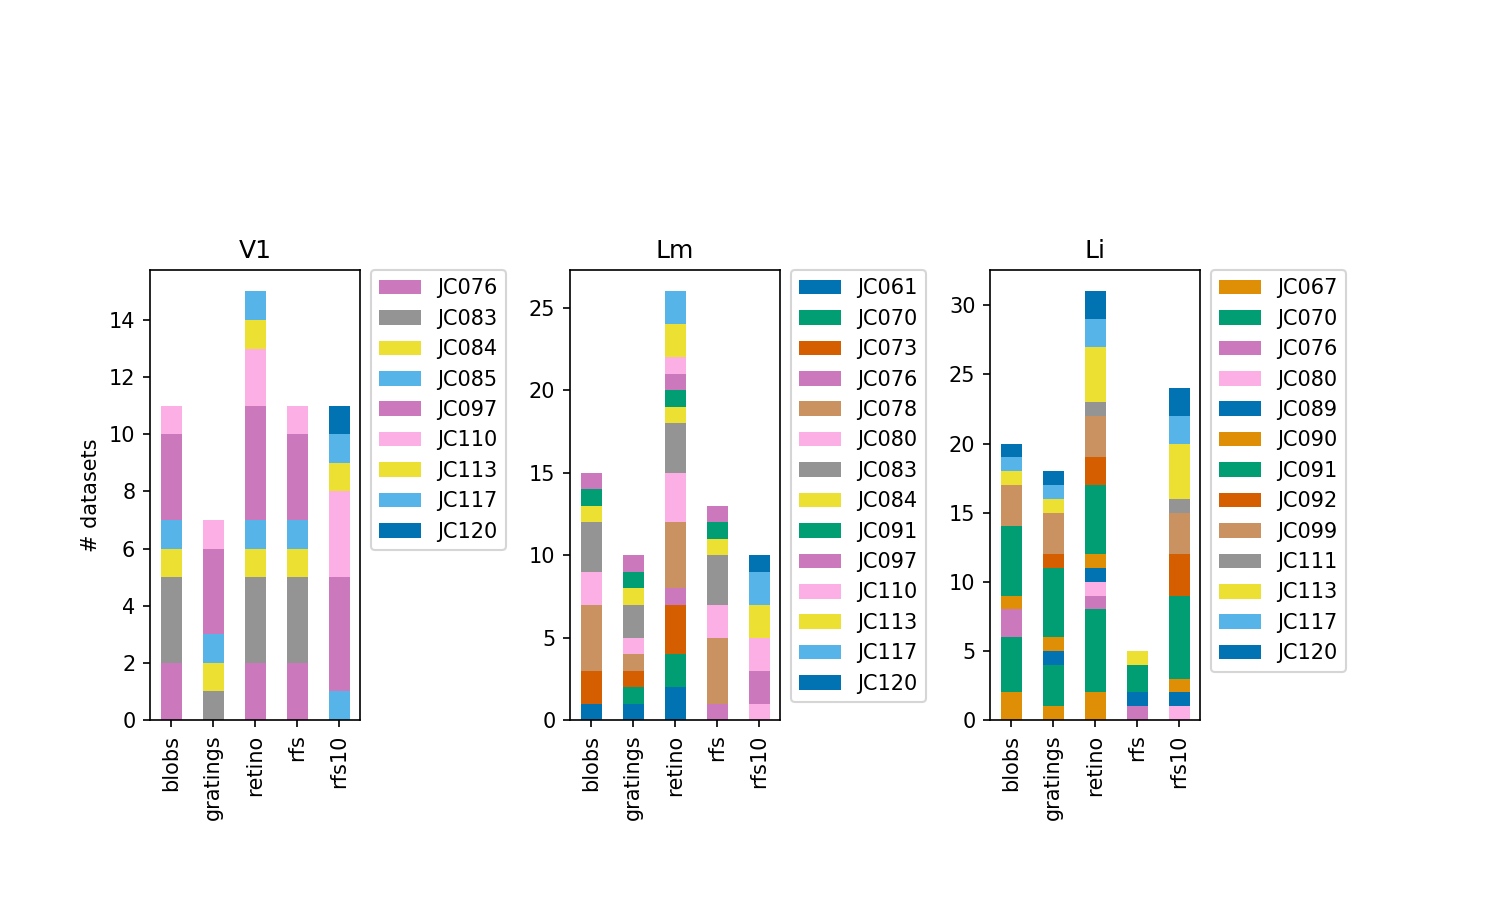

In [21]:
# Give each animal unique color:
animal_color_list = sns.color_palette('colorblind', len(animal_names))
animal_cdict = dict((animal, animal_color_list[ai]) for ai, animal in enumerate(animal_names))

fig, axes = pl.subplots(1, 3, figsize=(10, 6))

for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    color_list = [animal_cdict[a] for a in sdata[sdata['visual_area']==visual_area]['animalid']]
    group_by_animal = sdata[sdata['visual_area']==visual_area].groupby(['animalid', 'experiment'])\
                            .size().reset_index().pivot(columns='animalid', index='experiment', values=0)
    color_list = [animal_cdict[a] for a in group_by_animal.columns.tolist()]
    group_by_animal.plot(kind='bar', stacked=True, ax=ax, colors=color_list)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('')
    ax.set_title(visual_area)
    if ai == 0:
        ax.set_ylabel('# datasets')
pl.subplots_adjust(wspace=1, top=0.7, bottom = 0.2, left=0.1, right=0.8)

pl.savefig(os.path.join(dst_dir, 'awake_datasets_exp_by_animal.png'))


<IPython.core.display.Javascript object>


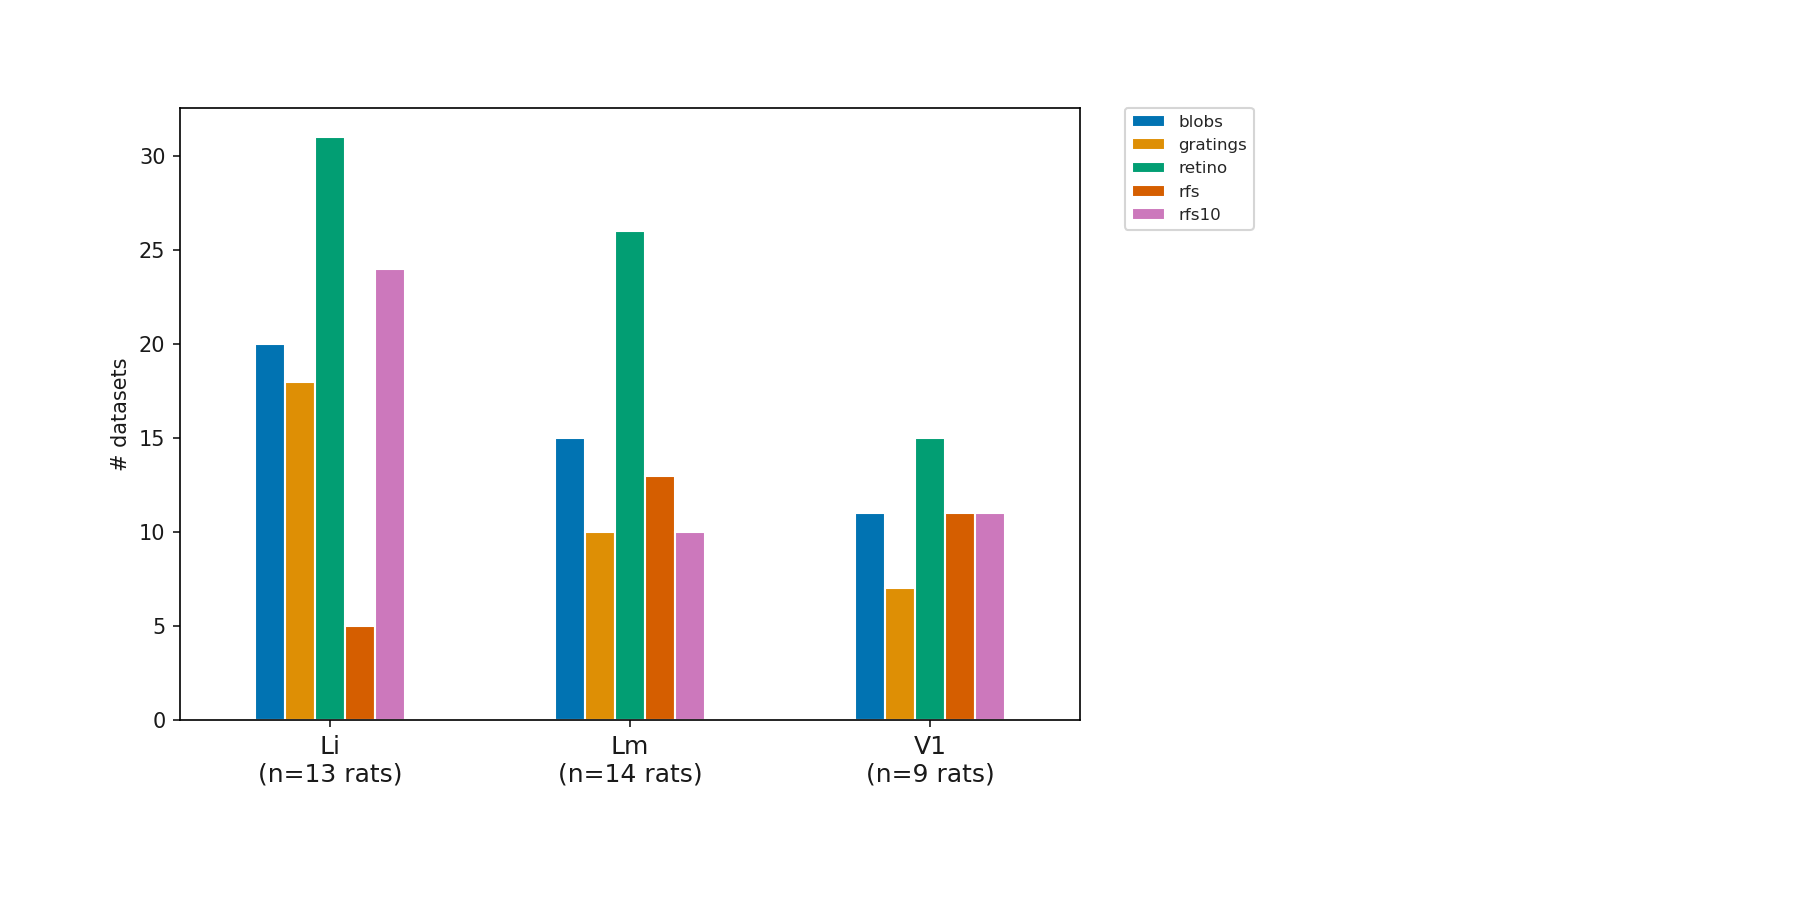

In [22]:
fig, ax = pl.subplots(figsize=(12, 6))
sns.set(style="white")
sns.set_palette('colorblind')
# ax = axes[0]
# ax.bar(range(len(visual_areas)), [len(n) for n in n_animals_per.values])
# ax.set_xticklabels(n_animals_per.index.tolist())

#ax = axes[0]
group_by_area.plot(kind='bar', stacked=False, ax=ax)
ax.set_ylabel('# datasets')
v_area = n_animals_per.index.tolist()
v_nrats = [len(n) for n in n_animals_per.values]
ax.set_xticklabels(['%s\n(n=%i rats)' % (v, n) for v, n in zip(v_area, v_nrats)], rotation=0, fontsize=12)

ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

pl.subplots_adjust(wspace=1, bottom=0.2, right=0.6, left=0.1)
ax.set_xlabel('')

pl.savefig(os.path.join(dst_dir, 'awake_datasets_area_by_experiment.png'))


In [20]:
sessions_by_animal = sessiondata.groupby(['animalid', 'session'])['fov'].unique()

In [21]:
sessions_by_animal

animalid  session 
JC076     20190420                   [FOV1_zoom2p0x]
          20190422                   [FOV1_zoom2p0x]
          20190423                   [FOV1_zoom2p0x]
          20190501                   [FOV1_zoom2p0x]
          20190502                   [FOV1_zoom2p0x]
JC078     20190426                   [FOV1_zoom2p0x]
          20190430                   [FOV1_zoom2p0x]
          20190504                   [FOV1_zoom2p0x]
          20190509                   [FOV1_zoom2p0x]
          20190513                   [FOV1_zoom2p0x]
JC080     20190506                   [FOV1_zoom2p0x]
          20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
          20190603                   [FOV1_zoom2p0x]
JC083     20190507                   [FOV1_zoom2p0x]
          20190508                   [FOV1_zoom2p0x]
          20190510                   [FOV1_zoom2p0x]
          20190511                   [FOV1_zoom2p0x]
          20190512                   [FOV1_zoom2p0x]
          20190517         

In [22]:
sessions_by_animal['JC080']

session
20190506                   [FOV1_zoom2p0x]
20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
20190603                   [FOV1_zoom2p0x]
Name: fov, dtype: object

In [23]:
session_list

NameError: name 'session_list' is not defined

In [34]:
aggregate_session_dir = os.path.join(datasetdir, 'session_stats')
if not os.path.exists(aggregate_session_dir):
    os.makedirs(aggregate_session_dir)

In [42]:
sessions_by_animal

animalid  session 
JC076     20190420                   [FOV1_zoom2p0x]
          20190422                   [FOV1_zoom2p0x]
          20190423                   [FOV1_zoom2p0x]
          20190501                   [FOV1_zoom2p0x]
          20190502                   [FOV1_zoom2p0x]
JC078     20190426                   [FOV1_zoom2p0x]
          20190430                   [FOV1_zoom2p0x]
          20190504                   [FOV1_zoom2p0x]
          20190509                   [FOV1_zoom2p0x]
          20190513                   [FOV1_zoom2p0x]
JC080     20190506                   [FOV1_zoom2p0x]
          20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
          20190603                   [FOV1_zoom2p0x]
JC083     20190507                   [FOV1_zoom2p0x]
          20190508                   [FOV1_zoom2p0x]
          20190510                   [FOV1_zoom2p0x]
          20190511                   [FOV1_zoom2p0x]
          20190512                   [FOV1_zoom2p0x]
          20190517         

In [48]:
sessiondata['animalid'].unique()

array(['JC084', 'JC091', 'JC085', 'JC090', 'JC099', 'JC097', 'JC076',
       'JC078', 'JC080', 'JC083'], dtype=object)

In [ ]:
for animalid in sessiondata['animalid'].unique():
    session_list = sessions_by_animal[animalid].index.tolist()
    for session in session_list:
        fovs = sessions_by_animal[animalid][session]

        for fov in fovs:
            stats.visualize_session_stats(animalid, session, fov, create_new=False, altdir=aggregate_session_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/summaries
creating new session object...
[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 4 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC084 | 20190522 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(246708, 6)
... making equal
loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Found 114 responsive cells.
... loading data array (combined_rf

<IPython.core.display.Javascript object>

--- done! ---
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/summaries
creating new session object...
[JC084] 20190525 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 4 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC084 | 20190525 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(228018, 6)
... making equal
incorrect reps / condn...
loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Found 43 responsive cel

<IPython.core.display.Javascript object>

--- done! ---
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/summaries
creating new session object...
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 5 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC091 | 20190602 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(252048, 6)
... making equal
incorrect reps / condn...
ERROR LOADING DATA

loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Fou

In [37]:
reload(stats)

<module 'pipeline.python.classifications.run_experiment_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/run_experiment_stats.pyc'>

In [25]:
from pipeline.python.classifications import run_experiment_stats as stats

In [29]:
for animalid in session_by_animal.index.tolist():
    

Index([u'JC076', u'JC078', u'JC080', u'JC083', u'JC084', u'JC085', u'JC090',
       u'JC091', u'JC097', u'JC099'],
      dtype='object', name=u'animalid')

<IPython.core.display.Javascript object>


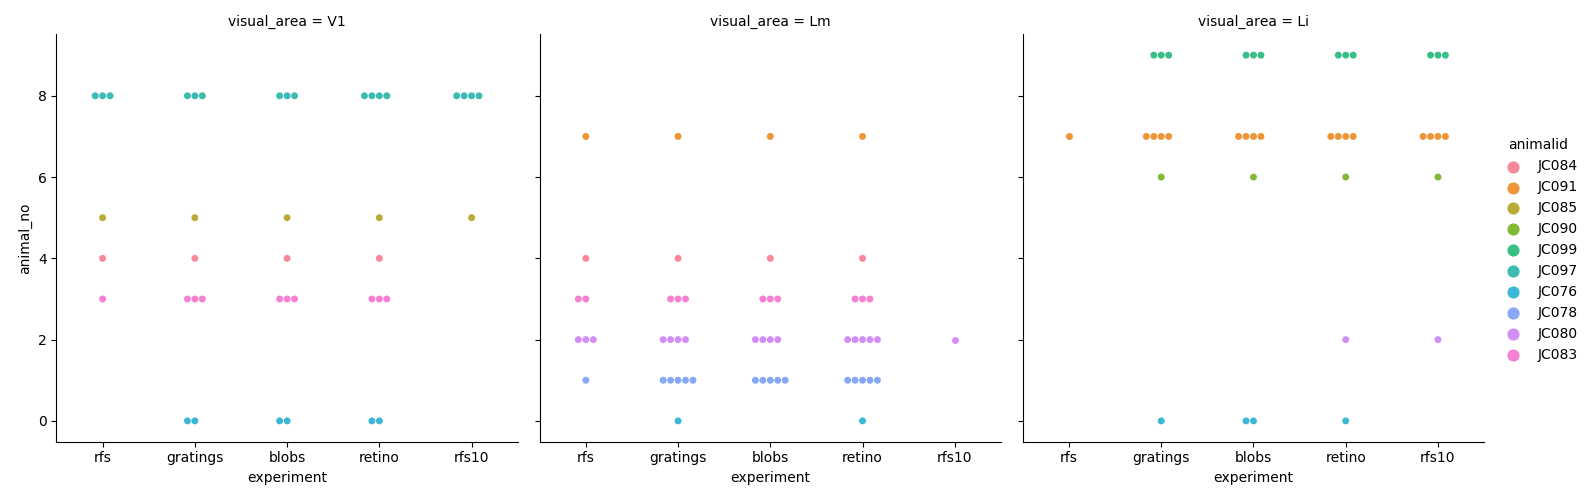

In [69]:
sns.catplot(x='experiment', y='animal_no', col='visual_area', hue='animalid', kind='swarm', data=sessiondata)

In [29]:
sessiondata.dtypes

animalid       object
experiment     object
visual_area    object
exp_no          int64
dtype: object

In [ ]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC097'
session = '20190617'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [ ]:
# Create output_dir

output_dir = os.path.join(rootdir, animalid, session, fov, 'summaries')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(output_dir)

In [ ]:
session_outfile = os.path.join(output_dir, 'sessiondata.pkl')
create_new = False

if os.path.exists(session_outfile) and create_new is False:
    print("loading session object...")
    with open(session_outfile, 'rb') as f:
        S = pkl.load(f)

else:
    print("creating new session object...")
    S = util.Session(animalid, session, fov, rootdir=rootdir)
    S.load_data(traceid=traceid, trace_type='corrected')
    
    # Save session data object
    with open(session_outfile, 'wb') as f:
        pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [ ]:
responsive_test = 'ROC'

mag_ratio_thr = 0.01
#rf_fit_thr = 0.5
gdfs = {}
for exp_name, exp in S.experiments.items():
    
    print("[%s] Loading roi lists..." % exp_name)
    
    estats = S.get_grouped_stats(exp, responsive_test=responsive_test, responsive_thr=mag_ratio_thr)
    
    gdfs[estats.experiment_id] = estats
    

In [ ]:
all_values = []
for exp_name in exp_colors.keys():
    all_values.extend(gdfs[exp_name].gdf.max()['meanstim'].values)